# Basic `alphatools` workflow

In [ ]:
%load_ext autoreload
%autoreload 2

import logging

from data_handler import DataHandler

import alphatools as at
from alphatools.pl.figure import create_figure, label_axes
from alphatools.pl.plots import Plots


logging.basicConfig(level=logging.INFO)

INFO:rdkit:Enabling RDKit 2024.03.3 jupyter extensions
/Users/vincenthbrennsteiner/miniconda3/envs/alphaverse/lib/python3.11/site-packages/alphabase/tools/data_downloader.py:4: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## Basic EDA on a synthetic example dataset:

1. Generate example data
2. Filter for data completeness on sample level
3. Visualize samples as histograms
4. Save data

In [ ]:
output_directory = "./example_outputs/03_basic_workflow/"

### Generate an example dataset as an anndata.AnnData instance

### Filter by data completeness:

Remove features which have more than the allowed fraction of missing values

In [ ]:
adata = DataHandler("synthetic_3x2").get_data()

print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

#  filter out features with more than 25 % missing values
adata = at.pp.filter_data_completeness(
    adata=adata,
    max_missing=0.25,
)

print("The numeric data in the anndata object:")
display(adata.to_df().head())

print("The sample-level metadata in the anndata object:")
display(adata.obs.head())

print("The feature-level metadata in the anndata object:")
display(adata.var.head())

Creating synthetic data using <function create_synthetic_data_3x2 at 0x111d51260>() .. 
The numeric data in the anndata object:


,gene_0,gene_1,gene_2
cell_0,NaN,4.400157,8.978738
cell_1,2.240893,5.867558,7.022722
cell_2,NaN,3.848643,7.896781
cell_3,0.410599,4.144044,9.454274
cell_4,NaN,4.121675,8.443863


The sample-level metadata in the anndata object:


,celltype
cell_0,A
cell_1,A
cell_2,A
cell_3,A
cell_4,A


The feature-level metadata in the anndata object:


,alternative_name
gene_0,G0
gene_1,G1
gene_2,G2


INFO:root:pp.filter_data_completeness(): Dropped 1 / 3 features with >0.25 missing in any group.


The numeric data in the anndata object:


,gene_1,gene_2
cell_0,4.400157,8.978738
cell_1,5.867558,7.022722
cell_2,3.848643,7.896781
cell_3,4.144044,9.454274
cell_4,4.121675,8.443863


The sample-level metadata in the anndata object:


,celltype
cell_0,A
cell_1,A
cell_2,A
cell_3,A
cell_4,A


The feature-level metadata in the anndata object:


,alternative_name
gene_1,G1
gene_2,G2


In [ ]:
adata

AnnData object with n_obs × n_vars = 100 × 2
    obs: 'celltype'
    var: 'alternative_name'

### Visualize the distribution of values in different levels of an observational metadata variable

In this example, check the distribution of "gene_1" expression values per cell type.

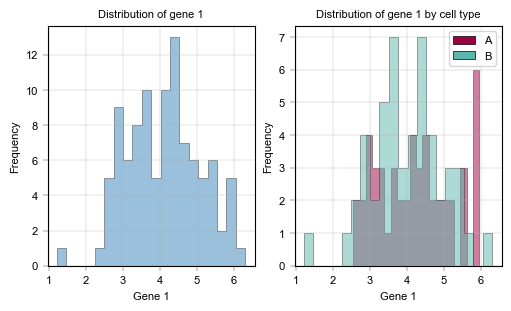

In [ ]:
# Apply the AxisManager to make axes iterable and apply consistent AlphaTools styling.
# Axes can also be accessed directly by indexing the axm object.
fig, axm = create_figure(nrows=1, ncols=2, figsize=(5, 3))

# Plot.histogram handles adata natively. Columns from the data and metadata are accessible
# Focus on the distribution of cell types in gene_1
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="gene_1",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "Gene 1", "Frequency", "Distribution of gene 1")

# Focus on the distribution of cell types in gene_1
ax = axm.next()
Plots.histogram(
    data=adata,
    value_column="gene_1",
    color_map_column="celltype",
    bins=20,
    legend="auto",
    ax=ax,
    hist_kwargs={"alpha": 0.5, "histtype": "stepfilled", "linewidth": 0.5, "edgecolor": "black"},
)
label_axes(ax, "Gene 1", "Frequency", "Distribution of gene 1 by cell type")

# save figure
save_figure(
    fig=fig,
    filename="sample_histogram.png",
    output_dir=output_directory,
    dpi=300,
    transparent=False,
)

### Running PCA

PCA can not be computed on matrices with missing values. Therefore, prior to PCA, we will create a list of 'core proteins' of proteins detected in all observations, save it in the feature meta data frame (adata.var) and run PCA on the shortlisted proteins. 

In [ ]:
# assuming that the data is already normalized, we can proceed with PCA
adata.layers["log2"] = adata.X.copy()

In [ ]:
# add a new column to the adata.var object with the name "isCore" to indicate whether the feature is part of the core proteome
# The core proteome is defined as the set of features that are detected in of the samples
add_core_proteome_mask(adata, layer="log2", new_column_name="is_core")

# view hoe many features are part of the core proteome
print("The number of features in the core proteome:")
print(adata.var["is_core"].value_counts())

# run PCA on the data
pca(adata, layer="log2", meta_data_mask_column_name="is_core", n_comps=1)


# view the PCA results
print("The dimensions of PC coordinates in the adata.obs are (n_obs x n_comp):")
print(adata.obsm["X_pca"].shape)
print("The PCA loadings in the adata.varm are (n_var x n_comp):")
print(adata.varm["PCs"].shape)
print("Ratio of explained variance (n_comp):")
print(adata.uns["pca"]["variance_ratio"])
print("The explained variance (n_comp):")
print(adata.uns["pca"]["variance"])

INFO:alphatools.pp.metadata:Adding core proteome mask to feature metadata
INFO:alphatools.pp.metadata:'is_core' column added to data.var to classify core proteins
INFO:alphatools.pp.embeddings:computing PCA


The number of features in the core proteome:
is_core
True    2
Name: count, dtype: int64
The dimensions of PC coordinates in the adata.obs are (n_obs x n_comp):
(100, 1)
The PCA loadings in the adata.varm are (n_var x n_comp):
(2, 1)
Ratio of explained variance (n_comp):
[0.5118724]
The explained variance (n_comp):
[0.99113042]


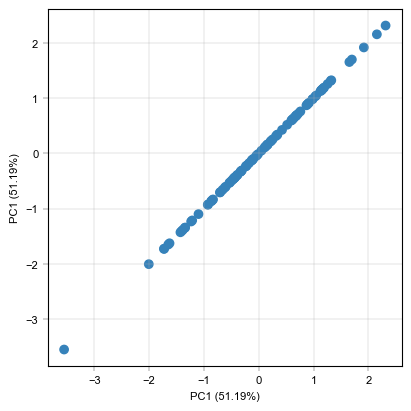

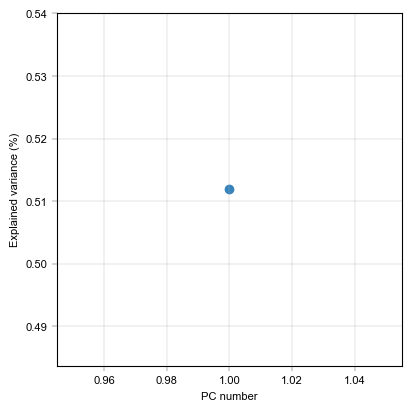

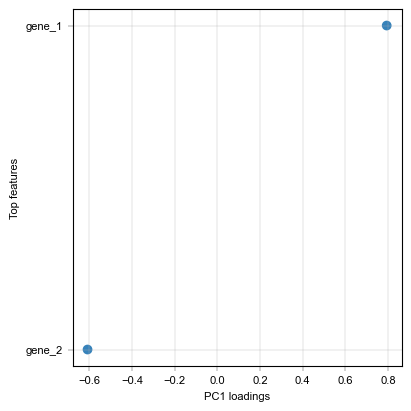

In [ ]:
# Plot the PCA results
# Create a figure with a single axis for the PCA plot (we only have one component sinnce nFeatures = 2)

fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()

Plots.plot_pca(
    data=adata,
    ax=ax,
    pc_x=1,
    pc_y=1,
    label=False,
    label_column=None,
    pca_embeddings_layer_name="X_pca",
    pca_variance_layer_name="pca",
)

# scree plot (again, we only have one component, so the scree plot will only show one point)
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.scree_plot(data=adata, ax=ax, n_pcs=50, pca_variance_layer_name="pca")


# show top loadings of the PCA (shows top loadings on absolute value for a selected component)
fig, axm = create_figure(1, 1, figsize=(4, 4))
ax = axm.next()
Plots.plot_pca_loadings(data=adata, ax=ax, dim=1, nfeatures=2)